In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error
from scipy import stats 
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import re
from scipy.stats import norm 

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from scipy.interpolate import interp1d

import wget

sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1. Data Understanding

First we have to find data related to Dioxid of Carbone(C02) concentration in the Atmosphere. We can get this information from the Scripps Institution of Oceanography which can shoe monthly, weekly, dayli datasets. For our project, we will use the montly report: monthly_in_situ_co2_mlo.csv.
- source: https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

The information recollected comes the observatory located at about 3,400 m altitude on Mauna Loa Volcano on Hawaii Island. This place has not influence of changing CO2 due it is near local vegetation and the wind prevail well-mixed air to the site. This information is provided from March 1958.



In [14]:
# Download raw data from source:
DataRaw_C02_url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv'
DataRaw_C02 = wget.download(DataRaw_C02_url)
print(DataRaw_C02)

monthly_in_situ_co2_mlo (1).csv


In [147]:
# Create the dataframe from csv file:
cols = ["year", "month", "date1", "date2", "co2", "co2_season_adj", "co2_spline_season_adj", "co2_spline", "co2_fill_7", "co2_fill_8"]
df_co2=pd.read_csv("./monthly_in_situ_co2_mlo.csv", skiprows = 57, header=None, names=cols)
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 780 data points of 10 features


,year,month,date1,date2,co2,co2_season_adj,co2_spline_season_adj,co2_spline,co2_fill_7,co2_fill_8
0,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
2,1958,3,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.70,317.88,315.07,317.51,314.70


## 2. Pre-Processing

After a quick review, the raw dataset has some information which need to be pre-processed before using in the model:
- Usage only the columns year, month, co2(ppm).
- Add columns like time $t= (t+0.5)/12$ which normalize the time by year.
- Delete comments in " " " and headers which cannot help us to understand the data(skiprows = 57).
- Drop co2 values equal to -99.99 which are some inhomogeneities or filled ad missing values
- Drop NaN values and reset index.

In [148]:
# Pre-process the dataset:
df_co2 = df_co2.iloc[:,[x for x in range(df_co2.shape[1]) if x in [0,1,4]]]
df_co2["time"] = [(i+0.5)/12 for i in range(0, df_co2.iloc[:,0].size)]
df_co2[df_co2 == -99.99] = np.NaN
df_co2 = df_co2.dropna()
df_co2 = df_co2.reset_index(drop=True)
print('Dataframe has {:d} data points of {:d} features'.format(df_co2.shape[0],df_co2.shape[1]))
df_co2.head()

Dataframe has 768 data points of 4 features


,year,month,co2,time
0,1958,3,315.71,0.208333
1,1958,4,317.45,0.291667
2,1958,5,317.51,0.375000
3,1958,7,315.87,0.541667
4,1958,8,314.93,0.625000


For further modeling, we will split the data into train and test dataset. 

In [149]:
# Take values for x and y
x = df_co2["time"].values
y = df_co2["co2"].values

# Split data
x_train, x_test, y_train, y_test = train_test_split(x.reshape(-1,1), y.reshape(-1,1), test_size = 0.20, shuffle=False )

# Define training and testing dataset:
df_co2_train = df_co2[0:len(x_train)]
df_co2_test = df_co2[len(x_train):len(df_co2)]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, df_co2_train.shape, df_co2_test.shape)

(614, 1) (154, 1) (614, 1) (154, 1) (614, 4) (154, 4)


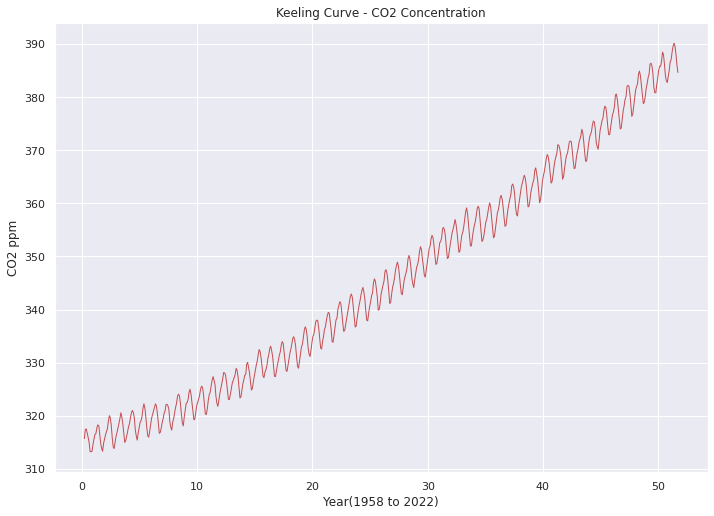

In [152]:
# Plotting The Keeling Curve, this is how look the CO2 concentration by year
plt.plot(x_train[:,0],y_train[:,0], linewidth = 1, color = 'r')
plt.xlabel('Year(1958 to 2022)')
plt.ylabel('CO2 ppm')
plt.title('Keeling Curve - CO2 Concentration')
plt.savefig('./images/CO2-curve.jpg')
plt.show()

## 3. Building Model

We will use information regarded to C02 concentration which can be model as:

$$ C_ i = F(t_ i) + P_ i + R_ i $$

- $F(t_ i)$ : Trendy pattern
- $P_ i$ : Seasonal pattern
- $R_ i$ : Residual

Later during evaluation we will see if this decomposition is meaningful. The main idea is to transform the data into stationarity


### Trendy pattern:

For this part, we need to go throught some models like linear regression, polynomical grade 2 or 3 and try to verify which one can fit better.

In [153]:
# Linear Regression Model

modelLR = LinearRegression().fit(x_train, y_train)

alpha0 = modelLR.intercept_
alpha1 = modelLR.coef_[0]
y_pred_train = modelLR.predict(x_train)

# Evaluation for testing dataset
y_pred_test = modelLR.predict(x_test)
R_1 = modelLR.score(x_test, y_test)
rmse_1 = mean_squared_error(y_true=y_test,y_pred=y_pred_test,squared=False)
mape_1 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test)

print("Linear Regression Model:")
print("=========================")
print("R2 score: ",R_1)
print("RMSE:",rmse_1)
print("MAPE: ", mape_1)
print("F(t) = {:f}*t + {:f}".format(alpha1[0], alpha0[0]))

Linear Regression Model:
R2 score:  -0.699047254153969
RMSE: 12.205045063273001
MAPE:  0.027995356835597913
F(t) = 1.430446*t + 308.558541


In [107]:
# Quadratic Model

grade = 2
Pft = PolynomialFeatures(grade, include_bias=False)
x_train_pol2 = Pft.fit_transform(x_train)
x_test_pol2 = Pft.fit_transform(x_test)

# Create model and fit it:
modelPoly2 = LinearRegression().fit(x_train_pol2, y_train)

alpha0 = modelPoly2.intercept_
alpha1 = modelPoly2.coef_[0][0]
alpha2 = modelPoly2.coef_[0][1]
y_pred_train_pol2 = modelPoly2.predict(x_train_pol2)

# Evaluation for testing dataset
y_pred_test_pol2 = modelPoly2.predict(x_test_pol2)
R_2 = modelPoly2.score(x_test_pol2, y_test)
rmse_2 = mean_squared_error(y_true=y_test,y_pred=y_pred_test_pol2,squared=False)
mape_2 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test_pol2)

print("Quadratic Model:")
print("=========================")
print("R2 score: ",R_2)
print("RMSE:",rmse_2)
print("MAPE: ", mape_2)
print("Quadratic Fit: F(t) = {:f}*t^2 + {:f}*t + {:f}".format(alpha2, alpha1, alpha0[0]))

Quadratic Model:
R2 score:  0.9093916972185182
RMSE: 2.8185169840722186
MAPE:  0.005867396936490818
Quadratic Fit: F(t) = 0.012107*t^2 + 0.799038*t + 314.132792


In [108]:
# Cubic Model

grade = 3
Pft = PolynomialFeatures(grade, include_bias=False)
x_train_pol3 = Pft.fit_transform(x_train)
x_test_pol3 = Pft.fit_transform(x_test)

# Create model and fit it:
modelPoly3 = LinearRegression().fit(x_train_pol3, y_train)

alpha0 = modelPoly3.intercept_
alpha1 = modelPoly3.coef_[0][0]
alpha2 = modelPoly3.coef_[0][1]
alpha3 = modelPoly3.coef_[0][2]
y_pred_train_pol3 = modelPoly3.predict(x_train_pol3)

# Evaluation for testing dataset
y_pred_test_pol3 = modelPoly3.predict(x_test_pol3)
R_3 = modelPoly3.score(x_train_pol3, y_train)
rmse_3 = mean_squared_error(y_true=y_test,y_pred=y_pred_test_pol3,squared=False)
mape_3 = mean_absolute_percentage_error(y_true=y_test,y_pred=y_pred_test_pol3)

print("Cubic Model:")
print("=========================")
print("R2 score: ",R_3)
print("RMSE:",rmse_3)
print("MAPE: ", mape_3)
print("Cubic Fit: F(t) = {:f}*t^3 + {:f}*t^2 + {:f}*t + {:f}".format(alpha3, alpha2, alpha1, alpha0[0]))

Cubic Model:
R2 score:  0.9897560738035467
RMSE: 4.173563988095543
MAPE:  0.008556662482153917
Cubic Fit: F(t) = -0.000077*t^3 + 0.018098*t^2 + 0.673546*t + 314.693445


Error Model:
R2 score:  -0.699047254153969 0.9093916972185182 0.9897560738035467
RMSE: 12.205045063273001 2.8185169840722186 4.173563988095543
MAPE:  0.027995356835597913 0.005867396936490818 0.008556662482153917 



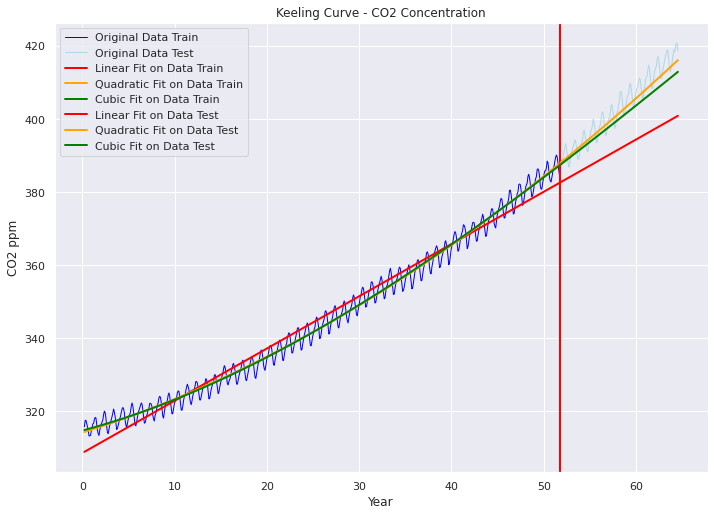

In [154]:
# Comparing Linear, Quadratic and Cubic Model Fit

plt.plot(x_train[:,0],y_train[:,0], linewidth = 1, color = 'blue', label ="Original Data Train")
plt.plot(x_test[:,0],y_test[:,0], linewidth = 1, color = 'lightblue', label ="Original Data Test")

plt.plot(x_train[:,0], y_pred_train, linewidth = 2, color = 'red', label ="Linear Fit on Data Train")
plt.plot(x_train[:,0], y_pred_train_pol2, linewidth = 2, color = 'orange', label ="Quadratic Fit on Data Train")
plt.plot(x_train[:,0], y_pred_train_pol3, linewidth = 2, color = 'green', label ="Cubic Fit on Data Train")

plt.axvline(x=x_test[0,:], ymin=0, ymax=9, linewidth = 2, color = 'red')

plt.plot(x_test[:,0], y_pred_test, linewidth = 2, color = 'red', label ="Linear Fit on Data Test")
plt.plot(x_test[:,0], y_pred_test_pol2, linewidth = 2, color = 'orange', label ="Quadratic Fit on Data Test")
plt.plot(x_test[:,0], y_pred_test_pol3, linewidth = 2, color = 'green', label ="Cubic Fit on Data Test")

print("Error Model:")
print("=========================")
print("R2 score: ",R_1, R_2, R_3)
print("RMSE:",rmse_1, rmse_2, rmse_3)
print("MAPE: ", mape_1, mape_2, mape_3, "\n")

plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2 ppm')
plt.title('Keeling Curve - CO2 Concentration')
plt.savefig('./images/Trendy-curve.jpg')
plt.show()

### Seasonal Pattern:

For model seasonal pattern, we can use the residuals of quadratic model because this model has a good RSME besides the other models. With this residual, we need to find the pattern which can be modeled. As we can see, this kind of residual has the seasonal form. We will use the mean of months and interpolate as a periodic function which will be replicate.



In [156]:
# Residual for Quadradic model
# Periodic Signal on Train Data
df_co2_train["R_quadratic"] = y_train[:,0] - y_pred_train_pol2[:,0]
df_co2_train.head(10)

/home/jhon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,month,co2,time,R_quadratic
0,1958,3,315.71,0.208333,1.410216
1,1958,4,317.45,0.291667,3.083125
2,1958,5,317.51,0.375000,3.075866
3,1958,7,315.87,0.541667,1.300843
4,1958,8,314.93,0.625000,0.293080
5,1958,9,313.21,0.708333,-1.494852
6,1958,11,313.33,0.875000,-1.511220
7,1958,12,314.67,0.958333,-0.239656
8,1959,1,315.58,1.041667,0.601739
9,1959,2,316.49,1.125000,1.442967


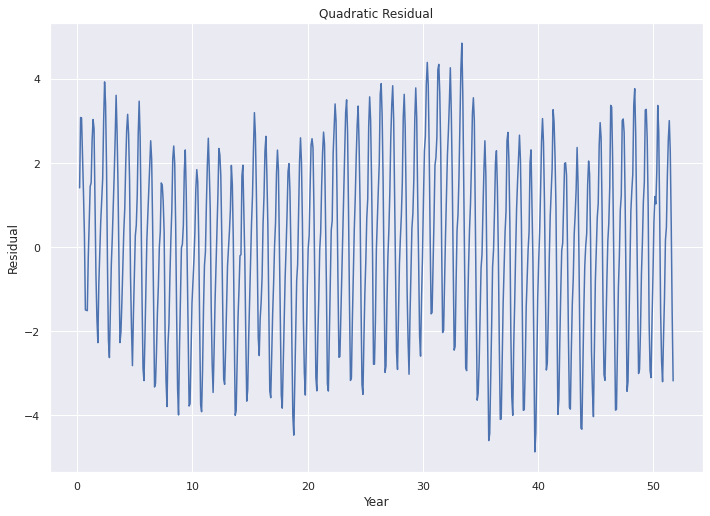

In [157]:
plt.plot(x_train[:,0], df_co2_train["R_quadratic"].values, color ='b')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.title('Quadratic Residual')
plt.show()

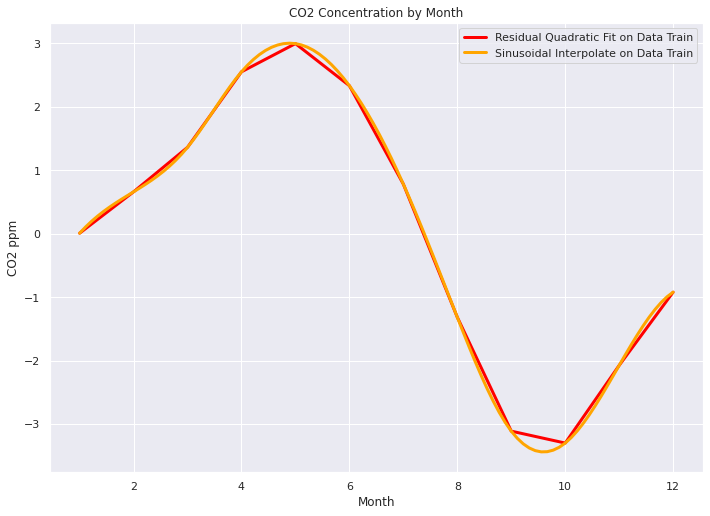

In [158]:
# Generating the periodic signal:
R_quadratic_by_month_train = df_co2_train.groupby("month").R_quadratic.mean()

# Interpolate
Time_Signal_periodic = np.linspace(1,12,num = 100, endpoint =True)
Signal_periodic = interp1d(R_quadratic_by_month_train.index, R_quadratic_by_month_train.values, kind = 'cubic')

# Plotting the interpolate function
plt.plot(R_quadratic_by_month_train.index, R_quadratic_by_month_train.values, linewidth = 3, color = 'red', label ="Residual Quadratic Fit on Data Train")
plt.plot(Time_Signal_periodic, Signal_periodic(Time_Signal_periodic), linewidth = 3, color = 'orange', label ="Sinusoidal Interpolate on Data Train")
plt.legend()
plt.xlabel('Month')
plt.ylabel('CO2 ppm')
plt.title('CO2 Concentration by Month')
plt.savefig('images/scatter.png')
plt.show()

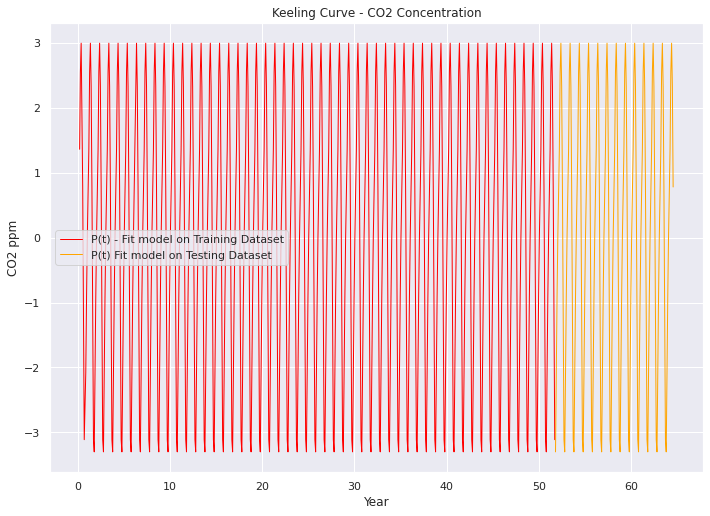

In [167]:
# Plotting the Seasonal Pattern:

Pi_train = []
for i in range(0, len(df_co2_train["time"])):
    Pi_train.append(Signal_periodic(df_co2_train.month.values[i]))

Pi_test = []
for i in range(0, len(df_co2_test["time"])):
    Pi_test.append(Signal_periodic(df_co2_test.month.values[i]))

plt.plot(x_train[:,0],Pi_train, linewidth = 1, color = 'red', label ="P(t) - Fit model on Training Dataset")
plt.plot(x_test[:,0],Pi_test, linewidth = 1, color = 'orange', label ="P(t) Fit model on Testing Dataset")
plt.title('Keeling Curve - CO2 Concentration')
plt.xlabel('Year')
plt.ylabel('CO2 ppm')
plt.legend()
plt.show()

Now we have the trendy and seasonal patterns, it is time to joint them and complete the model:

- Trendy Pattern: $ F(t) = 0.012107*t^2 + 0.799038*t + 314.132792$
- Seasonal Pattern: $ P(t) = Sinosoidal(interpolate -by- month) $

So $ C_i = F(t)+P(t) $

In [160]:
Ci_train = []
for i in range(0, len(df_co2_train["time"])):
    Ci_train.append(y_pred_train_pol2[i]+Signal_periodic(df_co2_train.month.values[i]))

Ci_test = []
for i in range(0, len(df_co2_test["time"])):
    Ci_test.append(y_pred_test_pol2[i]+Signal_periodic(df_co2_test.month.values[i]))


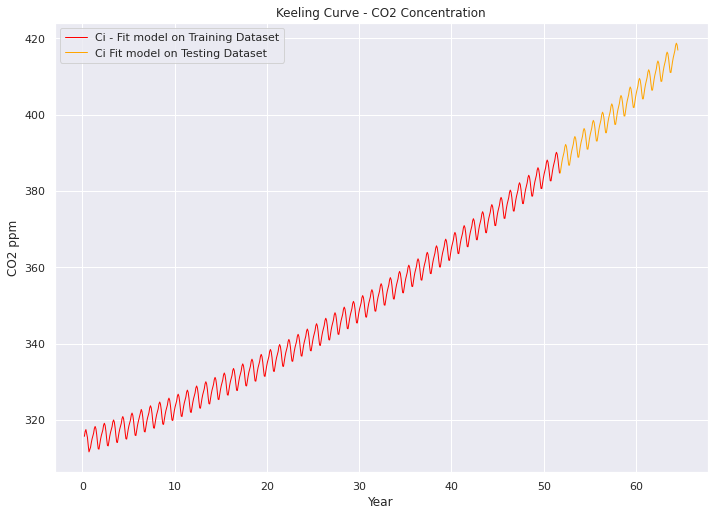

In [164]:
plt.plot(x_train[:,0],Ci_train, linewidth = 1, color = 'red', label ="Ci - Fit model on Training Dataset")
plt.plot(x_test[:,0],Ci_test, linewidth = 1, color = 'orange', label ="Ci Fit model on Testing Dataset")
plt.title('Keeling Curve - CO2 Concentration')
plt.xlabel('Year')
plt.ylabel('CO2 ppm')
plt.legend()
plt.show()

## 4. Evaluation

For this part, we can use the following metrics to evaluate over the test dataset:
- Evaluate RMSE:
    - Root Mean Square Error: $ \sqrt{ \sum\limits_{i=0}^{n} \frac{(y - y_{pred})^2}{n}} $ 
- Information Criteria AIC, BIC:
    - AIC (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$ 
    - BIC (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$ 
- Meaningfull evaluation

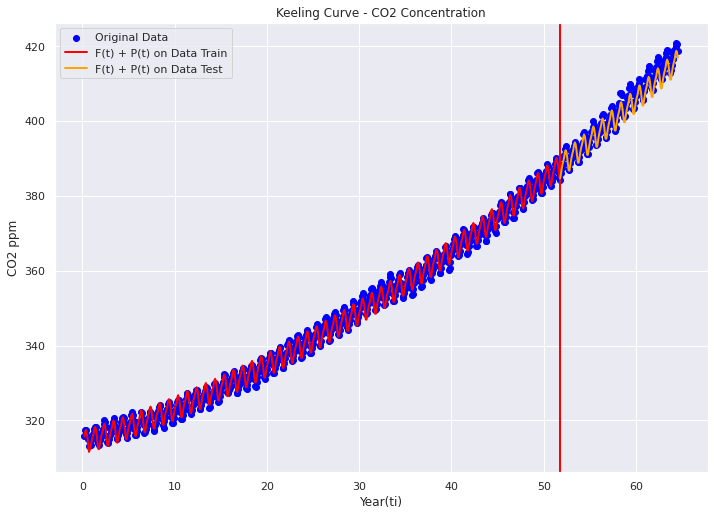

In [168]:
# Plotting The Keeling Curve
plt.scatter(x,y, linewidth = 1, color = 'blue', label ="Original Data" )
#plt.plot(x_train[:,0], y_pred_train_pol2, linewidth = 3, color = 'orange', label ="Quadratic Fit on Data Train")
#plt.plot(x_test[:,0], y_pred_test_pol2, linewidth = 3, color = 'red', label ="Quadratic Fit on Data Test")

plt.axvline(x=x_test[0,:], ymin=0, ymax=9, linewidth = 2, color = 'red')

plt.plot(x_train[:,0],Ci_train, linewidth = 2, color = 'red', label ="F(t) + P(t) on Data Train")
plt.plot(x_test[:,0],Ci_test, linewidth = 2, color = 'orange', label ="F(t) + P(t) on Data Test")
plt.legend()
plt.xlabel('Year(ti)')
plt.ylabel('CO2 ppm')
plt.title('Keeling Curve - CO2 Concentration')
plt.savefig('images/finalCi.png')
plt.show()

In [181]:
# RMSE for all models
rmse_1 = mean_squared_error(y_true=y_test,y_pred=y_pred_test,squared=False)
rmse_2 = mean_squared_error(y_true=y_test,y_pred=y_pred_test_pol2,squared=False)
rmse_sin = mean_squared_error(y_true=y_test,y_pred=Pi_test,squared=False)
rmse_ci = mean_squared_error(y_true=y_test,y_pred=Ci_test,squared=False)

print("Error Models Comparinson:")
print("=========================")
print("RMSE - Linear Model: ",rmse_1)
print("RMSE - Quadratic Model: ", rmse_2)
print("RMSE - Sinoidal Model: ", rmse_sin)
print("RMSE - Linear+Quadratic Model: ", rmse_ci)

Error Models Comparinson:
RMSE - Linear Model:  12.205045063273001
RMSE - Quadratic Model:  2.8185169840722186
RMSE - Sinoidal Model:  403.2159909879654
RMSE - Linear+Quadratic Model:  1.6761379284135005


In [180]:
# Function AIC, BIC

def evaluate_AIC(k, residuals):
    s_dev = np.std(residuals)
    log_likelihood = norm.logpdf(residuals, 0, scale=s_dev)
    return 2 * k - 2 * np.sum(log_likelihood)

def evaluate_BIC(k, residuals):
    s_dev = np.std(residuals)
    log_likelihood = norm.logpdf(residuals, 0, scale=s_dev)
    return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

In [184]:
# plt.plot(x, detrended, label='detrended data')

P_test = np.array(Pi_test).reshape(-1,1)
Ci_test = np.array(Ci_test).reshape(-1,1)

# y_pred_test
# y_pred_test_pol2
# Pi_test
# Ci_test

# Residuals Calculation

linear_residuals = y_test - y_pred_test
nonlinear_residuals = y_test - y_pred_test_pol2
sin_residuals = y_test - Pi_test
nonlinear_sin_residuals = y_test - Ci_test

for residual, label, DOF_used in zip([linear_residuals, nonlinear_residuals, sin_residuals, nonlinear_sin_residuals], 
                         ['linear', 'nonlinear', 'sinusoidal', 'Nonlinear+Sinoidal'],
                         [1, 2, 5, 7]):
    print('AIC with {} method is: {}'.format(label, evaluate_AIC(DOF_used, residual)))
    print('BIC with {} method is: {}'.format(label, evaluate_BIC(DOF_used, residual)))
    print('-'*20)

AIC with linear method is: 1918.707028906646
BIC with linear method is: 1921.7439815090595
--------------------
AIC with nonlinear method is: 767.0099028009191
BIC with nonlinear method is: 773.0838080057464
--------------------
AIC with sinusoidal method is: 42096479.288302734
BIC with sinusoidal method is: 42096494.47306575
--------------------
AIC with Nonlinear+Sinoidal method is: 755.0368639627404
BIC with Nonlinear+Sinoidal method is: 776.2955321796359
--------------------


In [188]:
Ft_min = np.min(y_pred_train_pol2)
Ft_max = np.max(y_pred_train_pol2)
Pi_min = np.min(R_quadratic_by_month_train)
Pi_max = np.max(R_quadratic_by_month_train)
Ri_min = np.min(y_train - Ci_train)
Ri_max = np.max(y_train - Ci_train)

print(Ft_min, Ft_max, Pi_min, Pi_max, Ri_min, Ri_max)
print("Ratio Ft/Pi : {:f} \nRatio Pi/Ri : {:f} ".format(np.abs((Ft_max-Ft_min)/(Pi_max-Pi_min)), np.abs((Pi_max-Pi_min)/(Ri_max-Ri_min))))

314.2997837816629 387.822024748456 -3.300503886883247 2.996078553883542 -1.7591178397198632 1.9398736013479834
Ratio Ft/Pi : 11.676531 
Ratio Pi/Ri : 1.702243 


### Conclusions:

- The ratio between the range of values of $Ft$ is 11 times that of $Pi$ which means trendy model is a good estimation. On the other hand, seasonal model can be seen as a refinement of the model and does not affect the linear trend.  
- The range of values of the residual is comparable, roughly 1.7 times the range of the residuals.
- AIC, BIC information for final model can be seen as a good approximation for eal CO2 concentrarion.
- RMSE of final model also has reach a bettet performance than quadratic and linear model.